---
# **Bayesian in Machine Learning**
## *MVA - Project*
## <u>**Authors**</u> : EL BAZ Adrian - FAURÉ Thomas
### <u>**Paper**</u> : On the Impact of the Activation Function on Deep Neural Networks Training - **Soufiane Hayou, Arnaud Doucet, Judith Rousseau**

---
> In this notebook, we replicate some of the results of the aforementioned paper. Code wasn't available for this work so we had to code from scratch.
>
> There are 2 main results in this notebook : 
> * <u>**Impact of the EOC initialization**</u>: We initialize a neural networks with appropriate values generated from normal distributions. We aim to show how EOC initialization impact the regularity neural network function.
>
> * <u>**Impact of the initialization of bias distribution's variance**</u> : We replicate results from Figure 6 in the paper **only** for the CIFAR10 dataset. Training time for this particular plot is very long. It is important to note that, we didn't run the code several times to get statistics such as the standard deviation or avarage of test accuracies for each depth value. 

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from torch import tensor
import torch.optim as optim

plt.style.use('ggplot')

In [0]:
class NN_EOC(nn.Module):
	
    def __init__(self, input_size, depth, hidden_units, output_size,activ,sigma_b,sigma_w):
        super(NN_EOC, self).__init__()

        ## BIAS VERSION
        #self.linear_input = nn.Linear(input_size, hidden_units,bias = True)
        #self.linears = nn.ModuleList([nn.Linear(hidden_units, hidden_units, bias = True) for i in range(depth-2)])
        #self.out = nn.Linear(hidden_units, output_size, bias = True)


        ## NO BIAS 
        self.linear_input = nn.Linear(input_size, hidden_units)
        self.linears = nn.ModuleList([nn.Linear(hidden_units, hidden_units) for i in range(depth-2)])
        self.out = nn.Linear(hidden_units, output_size)


        self.F = activ
        

        # Input layer init
        torch.nn.init.normal_(self.linear_input.weight, mean=0.0, std=sigma_w/np.sqrt(input_size))
        #torch.nn.init.normal_(self.linear_input.bias, mean=0.0, std=sigma_b)

        # Body init
        for i, l in enumerate(self.linears):
          if(i==0):
            torch.nn.init.normal_(self.linears[i].weight, mean=0.0, std=sigma_w/np.sqrt(hidden_units))
            #torch.nn.init.normal_(self.linears[i].bias, mean=0.0, std=sigma_b)
          else :     
            torch.nn.init.normal_(self.linears[i].weight, mean=0.0, std=sigma_w/np.sqrt(hidden_units))
            #torch.nn.init.normal_(self.linears[i].bias, mean=0.0, std=sigma_b)


        # Output layer init
        torch.nn.init.normal_(self.out.weight, mean=0.0, std=sigma_w/np.sqrt(hidden_units))
        #torch.nn.init.normal_(self.out.bias, mean=0.0, std=sigma_b)


    def forward(self, x):

        x = self.linear_input(x)
        x = self.F(x)
        for i, l in enumerate(self.linears):
          x = self.linears[i](x)
          x = self.F(x)
          return self.out(x)
        return x

## 1 - Impact of the EOC on the neural network's output regularity 

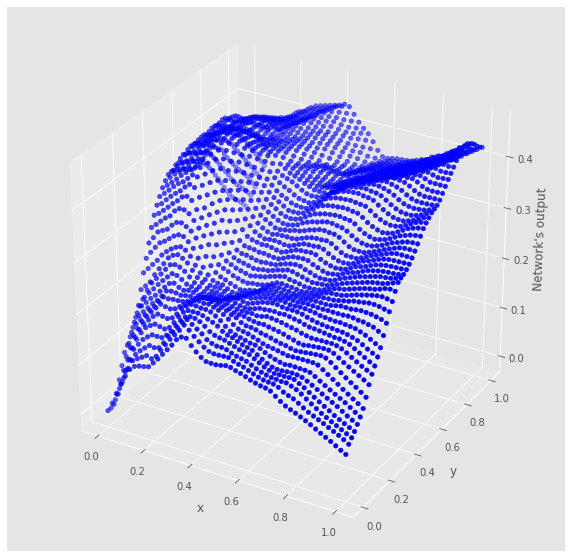

In [0]:
## Plots edge of chaos / Replication Figure 1 in the paper 
%matplotlib inline

# Use Vanilla NN with input size = 2 and output_size = 1

def f(x, y,model):
  """Returns the the network's output for x,y in [0,1]."""
  inp = torch.tensor([x,y],dtype=torch.double)
  model.eval()
  return model(inp)
# Initialize neural nets
untrained_nn = NN_EOC(input_size = 2,depth = 100, hidden_units = 300,output_size = 1, activ = torch.relu ,sigma_b=0,sigma_w=np.sqrt(2))

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

nbr_points = 50
x = np.linspace(0, 1, nbr_points,dtype=np.double)
y = np.linspace(0, 1, nbr_points,dtype=np.double)

X, Y = np.meshgrid(x, y)
Z = np.zeros((nbr_points, nbr_points))
for i in range(nbr_points):
    for j in range(nbr_points):
        Z[i,j] = untrained_nn(
            torch.tensor([X[i,j], Y[i,j]]))

#Z = f(X,Y,untrained_nn)
#Z = [[f(xx, yy,small_nn) for xx in  ]]
#print(Z.size())
#fig = plt.figure()
#ax = plt.axes(projection='3d')
#ax.plot_surface(X, Y, Z,cmap = 'RdBu')
#ax.plot_surface(X.ravel(), Y.ravel(), Z.ravel())
#ax.plot_wireframe(X,Y,Z)
ax.scatter3D(X, Y, Z,c= 'blue')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('Network\'s output');

In [0]:
print(X[3])

[0.         0.03448276 0.06896552 0.10344828 0.13793103 0.17241379
 0.20689655 0.24137931 0.27586207 0.31034483 0.34482759 0.37931034
 0.4137931  0.44827586 0.48275862 0.51724138 0.55172414 0.5862069
 0.62068966 0.65517241 0.68965517 0.72413793 0.75862069 0.79310345
 0.82758621 0.86206897 0.89655172 0.93103448 0.96551724 1.        ]


## 2 - Impact of initialization distribution parameters on the model's performance.

In [0]:
## CIFAR Dataset 

def init_CIFAR(type_data = 'CIFAR',batch_size = 64):
  """Init CIFAR/MNIST dataset."""

  # Standard pre-processing
  transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
  
  # Loaders
  if (type_data == 'CIFAR'):

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                          download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                            shuffle=False)

    classes = ('plane', 'car', 'bird', 'cat',
              'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
  else : 
    trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                          download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True)

    testset = torchvision.datasets.MNIST(root='./data', train=False,
                                        download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False)
    classes = ('0','1','2','3','4','5','6','7','8','9')
  return trainloader, testloader, classes

In [0]:
# Define a function to train different models depending of their depths 

class NN(nn.Module):
	
    def __init__(self, input_size, depth, hidden_units, output_size,activ,sigma):
        super(NN, self).__init__()
        self.linear_input = nn.Linear(input_size, hidden_units,bias = True)
        self.linears = nn.ModuleList([nn.Linear(hidden_units, hidden_units, bias = True) for i in range(depth-2)])
        self.out = nn.Linear(hidden_units, output_size, bias = True)
        self.F = activ
        

        # Input layer init
        torch.nn.init.normal_(self.linear_input.weight, mean=0.0, std=1.0/np.sqrt(input_size))
        torch.nn.init.normal_(self.linear_input.bias, mean=0.0, std=sigma)

        # Body init
        for i, l in enumerate(self.linears):
          if(i==0):
            torch.nn.init.normal_(self.linears[i].weight, mean=0.0, std=1.0/np.sqrt(hidden_units))
            torch.nn.init.normal_(self.linears[i].bias, mean=0.0, std=sigma)
          else :     
            torch.nn.init.normal_(self.linears[i].weight, mean=0.0, std=1.0/np.sqrt(hidden_units))
            torch.nn.init.normal_(self.linears[i].bias, mean=0.0, std=sigma)


        # Output layer init
        torch.nn.init.normal_(self.out.weight, mean=0.0, std=1.0/np.sqrt(hidden_units))
        torch.nn.init.normal_(self.out.bias, mean=0.0, std=sigma)


    def forward(self, x):
        #print(x.size())
        #x = x.permute(1,2,3,0)
        x = self.linear_input(x)
        x = self.F(x)
        for i, l in enumerate(self.linears):
          x = self.linears[i](x)
          x = self.F(x)
          return self.out(x)
        return x

def vanilla_NN_depth(depths, hidden_units = 300, epochs = 10,sigmas = [0.05,0.2,0.5],activation = 'tanh',dataset_type = 'CIFAR'):
  """Train different neural networks with various depths. 
  Parameters:
  ----------
  depths : array-like , associated depths to the different neural nets to train
  hidden_units : number of neurons within a hidden layer
  epochs : number of epochs 
  sigmas : array-like, different bias' normal distribution standard deviation
  activation : activation function to consider
  dataset_type : the dataset to train on. Only CIFAR and MNIST are implemented.
  
  Returns:
  --------
  accs : list of lists, accuracies for the various networks. Each inner-list in the outer-list is 
          storing results for a given sigma_b and various depths."""

  #assert( dataset_type == 'MNIST',"Only CIFAR and MNIST dataset are supported")
  #assert(activation == 'relu' or activation == 'elu',"Choose one of the following activation function : tanh/relu/elu")

  ## Init stats data structures 
  accuracies = [[], [], []]
  #accuracies = []
  b_s = 64
  ## Choosing the dataset
  if (dataset_type == 'CIFAR'):
    input_size = 32*32
    output_size = 10
    trainloader, testloader, classes = init_CIFAR(type_data = 'CIFAR',batch_size = b_s)
  else:
    input_size = 28*28
    output_size = 10 
    trainloader, testloader, classes = init_MNIST(type_data = 'MNIST',batch_size = b_s)



  ## Choosing the activation function
  if (activation == 'tanh'):
    act = torch.tanh
  elif(activation == 'relu'):
    act = torch.relu
  else:
    act = torch.elu

  
  ## Iterating over the desired depths 
  for (i,sigma) in enumerate(sigmas) : 
    for d in depths :
      model = NN(3*input_size,d,hidden_units,output_size,act,sigma)
      model.to(device)
      crit = nn.CrossEntropyLoss()
      if (d <= 150):
        learning_rate = 1e-3
      else :
        learning_rate = 1e-4

      optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
      train(epochs,batch_size = b_s,criterion = crit, optimizer = optimizer, model = model, train_loader =trainloader)
      acc = test(testloader, model)
      # Prediction test
      accuracies[i].append(acc) 
    print("Sigma #:{} - Done".format(i+1))
  return [depths, accuracies, epochs]

In [0]:
def train(num_epochs, batch_size, criterion, optimizer, model, train_loader):
    #train_error = []
    #train_loader = DataLoader(dataset, batch_size, shuffle=True)
    model.train()
    for epoch in range(num_epochs):
        epoch_average_loss = 0.0
        for (images, labels) in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            size_batch = images.size()[0]
            y_pre = model(images.view(size_batch, -1)) 

            loss = criterion(y_pre, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_average_loss += loss.item() * size_batch / len(train_loader)
        #train_error.append(epoch_average_loss)
        print('Epoch [{}/{}], Loss: {:.4f}'
                      .format(epoch+1, num_epochs, epoch_average_loss))
    #return train_error


### Test part 
def test(testloader,model):
  """Returns the accuracy of the current model on the test set images."""
  correct = 0
  total = 0
  with torch.no_grad():
      for (images, labels) in testloader:
          
          labels = labels.to(device)
          images = images.to(device)
          
          size_batch = images.size()[0]
          outputs = model(images.view(size_batch,-1))
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  #print('Accuracy of the network on the test set: %d %%' % (
  #    100 * correct / total))
  return correct/total
  

In [0]:
def visualize(stats_test1,stats_test2,stats_test3):
  """Plot the Test accuracy VS depth. to replicate Figure 6 in the paper. 
  Parameters:
  ----------
  stats_test : list, stats_test[0] : depths // stats_test[1] : test accuracy // stats_test[2]: epochs
  Displays: 
  ---------
  Test accuracy versus depth for 3 sets of results.
  1 set : test accuracy for different architectures
  """
  fig, (ax_1,ax_2,ax_3) = plt.subplots(nrows=1, ncols=3,
                                       sharex=True, figsize=(18, 7))

  ax_1.set_title('{} epochs'.format(stats_test1[2]))
  ax_1.plot(stats_test1[0],stats_test1[1][0], label = '$\sigma_{b}$ = 0.05')
  ax_1.plot(stats_test1[0],stats_test1[1][1], label = '$\sigma_{b}$ = 0.2' )
  ax_1.plot(stats_test1[0],stats_test1[1][2], label = '$\sigma_{b}$ = 0.5')
  ax_1.set_xlabel('Number of hidden layers')
  ax_1.set_ylabel('Test Accuracy')
  ax_1.set_xticks(stats_test1[0])

  ax_2.set_title('{} epochs'.format(stats_test2[2]))
  ax_2.plot(stats_test2[0],stats_test2[1][0], label = '$\sigma_{b}$ = 0.05')
  ax_2.plot(stats_test2[0],stats_test2[1][1], label = '$\sigma_{b}$ = 0.2' )
  ax_2.plot(stats_test2[0],stats_test2[1][2], label = '$\sigma_{b}$ = 0.5')
  ax_2.set_xlabel('Number of hidden layers')
  ax_2.set_ylabel('Test Accuracy')
  ax_2.set_xticks(stats_test2[0])

  ax_3.set_title('{} epochs'.format(stats_test3[2]))
  ax_3.plot(stats_test3[0],stats_test3[1][0], label = '$\sigma_{b}$ = 0.05')
  ax_3.plot(stats_test3[0],stats_test3[1][1], label = '$\sigma_{b}$ = 0.2' )
  ax_3.plot(stats_test3[0],stats_test3[1][2], label = '$\sigma_{b}$ = 0.5')
  ax_3.set_xlabel('Number of hidden layers')
  ax_3.set_ylabel('Test Accuracy')
  ax_3.set_xticks(stats_test3[0])


  # Add legends
  ax_1.legend(fontsize = 'medium')
  #ax_2.legend(font_size = 'medium')
  #ax_3.legend(font_size = 'medium')


  fig.suptitle('CIFAR10 - Depth versus accuracy on test set')
  plt.show()
  plt.figure



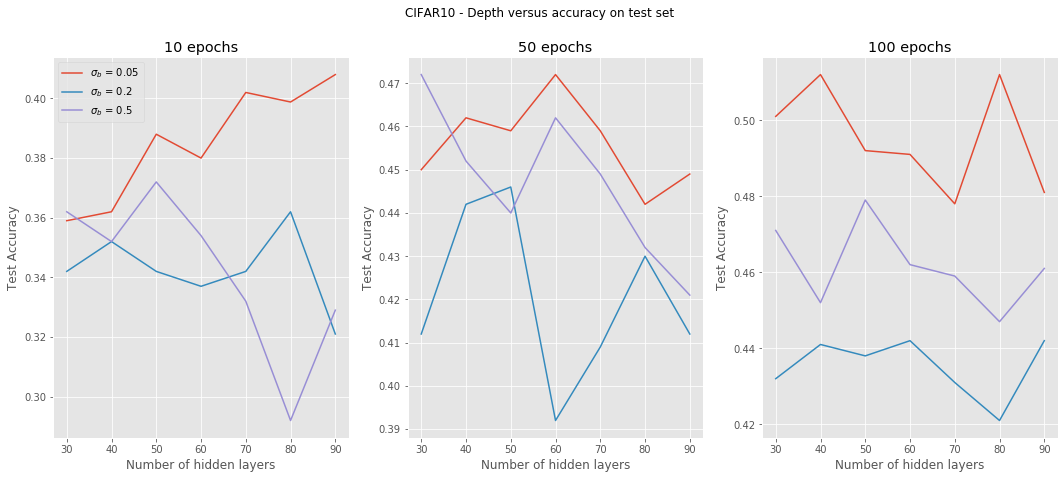

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

results_epoch10 = vanilla_NN_depth(depths=[30,40,50,60,70,80,90],hidden_units=300,epochs=10)
results_epoch50 = vanilla_NN_depth(depths=[30,40,50,60,70,80,90],hidden_units=300,epochs=50)
results_epoch100 = vanilla_NN_depth(depths=[30,40,50,60,70,80,90],hidden_units=300,epochs=100)
visualize(results_epoch10,results_epoch50,results_epoch100)